In [2]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import scipy

import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = f"1"

In [4]:
import torch
torch.__version__

'1.13.1'

# Download census-income dataset

In [0]:
# Found another version of the dataset here: what is the difference?
# https://www.kaggle.com/datasets/uciml/adult-census-income?resource=download

In [5]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [0]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

In [9]:
#out

# Load data and split

In [0]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [61]:
train

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Set
0,33,6,83311,9,12,2,4,0,4,1,0,0,12,39,wealthy,1
1,21,4,215646,11,8,0,6,1,4,1,0,0,39,39,wealthy,1
2,36,4,234721,1,6,2,6,0,2,1,0,0,39,39,wealthy,1
3,11,4,338409,9,12,2,10,5,2,0,0,0,39,5,wealthy,1
4,20,4,284582,12,13,2,4,5,4,0,0,0,39,39,wealthy,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,10,4,257302,7,11,2,13,5,4,0,0,0,37,39,wealthy,1
32556,23,4,154374,11,8,2,7,0,4,1,0,0,39,39,not_wealthy,2
32557,41,4,151910,11,8,6,1,4,4,0,0,0,39,39,wealthy,1
32558,5,4,201490,11,8,4,1,3,4,1,0,0,19,39,wealthy,1


In [13]:
#len(train_indices), len(valid_indices), len(test_indices)

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [14]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [15]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

# Define categorical features for categorical embeddings

In [16]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Grouped features

You can now specify groups of feature which will share a common attention.

This may be very usefull for features comming from a same preprocessing technique like PCA for example.

In [0]:
len(features)

In [20]:
for i, f in enumerate(features):
    print(i, f)

0 39
1  State-gov
2  77516
3  Bachelors
4  13
5  Never-married
6  Adm-clerical
7  Not-in-family
8  White
9  Male
10  2174
11  0
12  40
13  United-States


In [21]:
grouped_features = [[0, 1, 2], [8, 9, 10]]

# Network parameters

In [22]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":2,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax"
                 "grouped_features" : grouped_features
                }

clf = TabNetClassifier(**tabnet_params
                      )

/home/yoeriapts/workspace/tabnet/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Training

In [23]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [27]:
max_epochs = 50 if not os.getenv("CI", False) else 2 # In 'Contineuos Intergration' env, use only 2 epochs
max_epochs

50

In [28]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

In [29]:
# This illustrates the behaviour of the model's fit method using Compressed Sparse Row matrices
sparse_X_train = scipy.sparse.csr_matrix(X_train)  # Create a CSR matrix from X_train
sparse_X_valid = scipy.sparse.csr_matrix(X_valid)  # Create a CSR matrix from X_valid

# Fitting the model
clf.fit(
    X_train=sparse_X_train, y_train=y_train,
    eval_set=[(sparse_X_train, y_train), (sparse_X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    augmentations=aug, #aug, None
)

epoch 0  | loss: 0.58973 | train_auc: 0.83053 | valid_auc: 0.83009 |  0:00:03s
epoch 1  | loss: 0.48149 | train_auc: 0.85865 | valid_auc: 0.86324 |  0:00:05s
epoch 2  | loss: 0.45014 | train_auc: 0.8792  | valid_auc: 0.88146 |  0:00:07s
epoch 3  | loss: 0.43423 | train_auc: 0.89359 | valid_auc: 0.8969  |  0:00:09s
epoch 4  | loss: 0.41808 | train_auc: 0.90046 | valid_auc: 0.90128 |  0:00:11s
epoch 5  | loss: 0.41224 | train_auc: 0.90935 | valid_auc: 0.90779 |  0:00:13s
epoch 6  | loss: 0.39707 | train_auc: 0.91414 | valid_auc: 0.91294 |  0:00:15s
epoch 7  | loss: 0.39091 | train_auc: 0.91767 | valid_auc: 0.91609 |  0:00:17s
epoch 8  | loss: 0.38811 | train_auc: 0.92011 | valid_auc: 0.92051 |  0:00:19s
epoch 9  | loss: 0.37849 | train_auc: 0.9225  | valid_auc: 0.92103 |  0:00:21s
epoch 10 | loss: 0.38374 | train_auc: 0.92399 | valid_auc: 0.92277 |  0:00:23s
epoch 11 | loss: 0.37438 | train_auc: 0.92559 | valid_auc: 0.92437 |  0:00:25s
epoch 12 | loss: 0.36963 | train_auc: 0.92694 | vali

/home/yoeriapts/workspace/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
# This illustrates the warm_start=False behaviour
save_history = []

# Fitting the model without starting from a warm start nor computing the feature importance
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug, #aug, None
        compute_importance=False
    )
    save_history.append(clf.history["valid_auc"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

save_history = []  # Resetting the list to show that it also works when computing feature importance

# Fitting the model without starting from a warm start but with the computing of the feature importance activated
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug, #aug, None
        compute_importance=True # True by default so not needed
    )
    save_history.append(clf.history["valid_auc"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

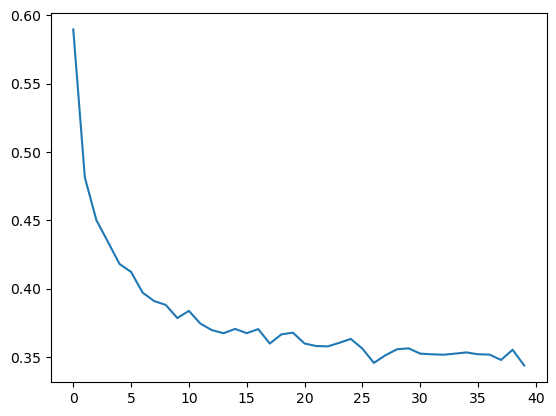

In [30]:
# plot losses
plt.plot(clf.history['loss'])

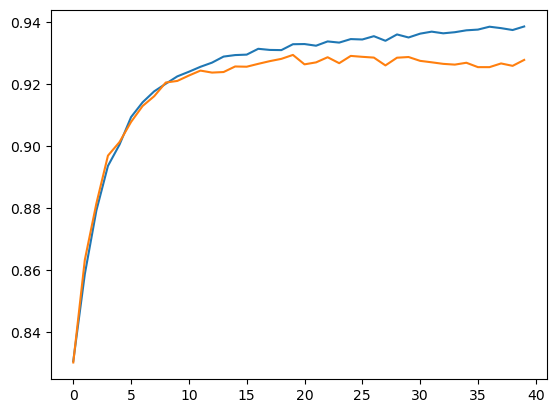

In [31]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

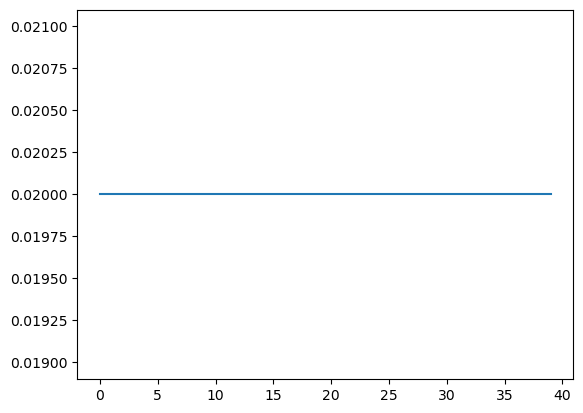

In [32]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [33]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9294301781212776
FINAL TEST SCORE FOR census-income : 0.9269001395113527


In [34]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [35]:
clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'wealthy'], dtype='<U11')

# Save and load Model

In [36]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [37]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

/home/yoeriapts/workspace/tabnet/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [38]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.9269001395113527


In [39]:
assert(test_auc == loaded_test_auc)

In [40]:
loaded_clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'wealthy'], dtype='<U11')

# Global explainability : feat importance summing to 1

In [41]:
clf.feature_importances_

array([0.03610309, 0.03610309, 0.03610309, 0.07889002, 0.15689536,
       0.27743735, 0.04600724, 0.06286622, 0.03285259, 0.03285259,
       0.03285259, 0.08224051, 0.07296272, 0.01583355])

# Local explainability and masks

In [42]:
explain_matrix, masks = clf.explain(X_test)

/tmp/ipykernel_1400782/3942983082.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels = features, rotation=45)


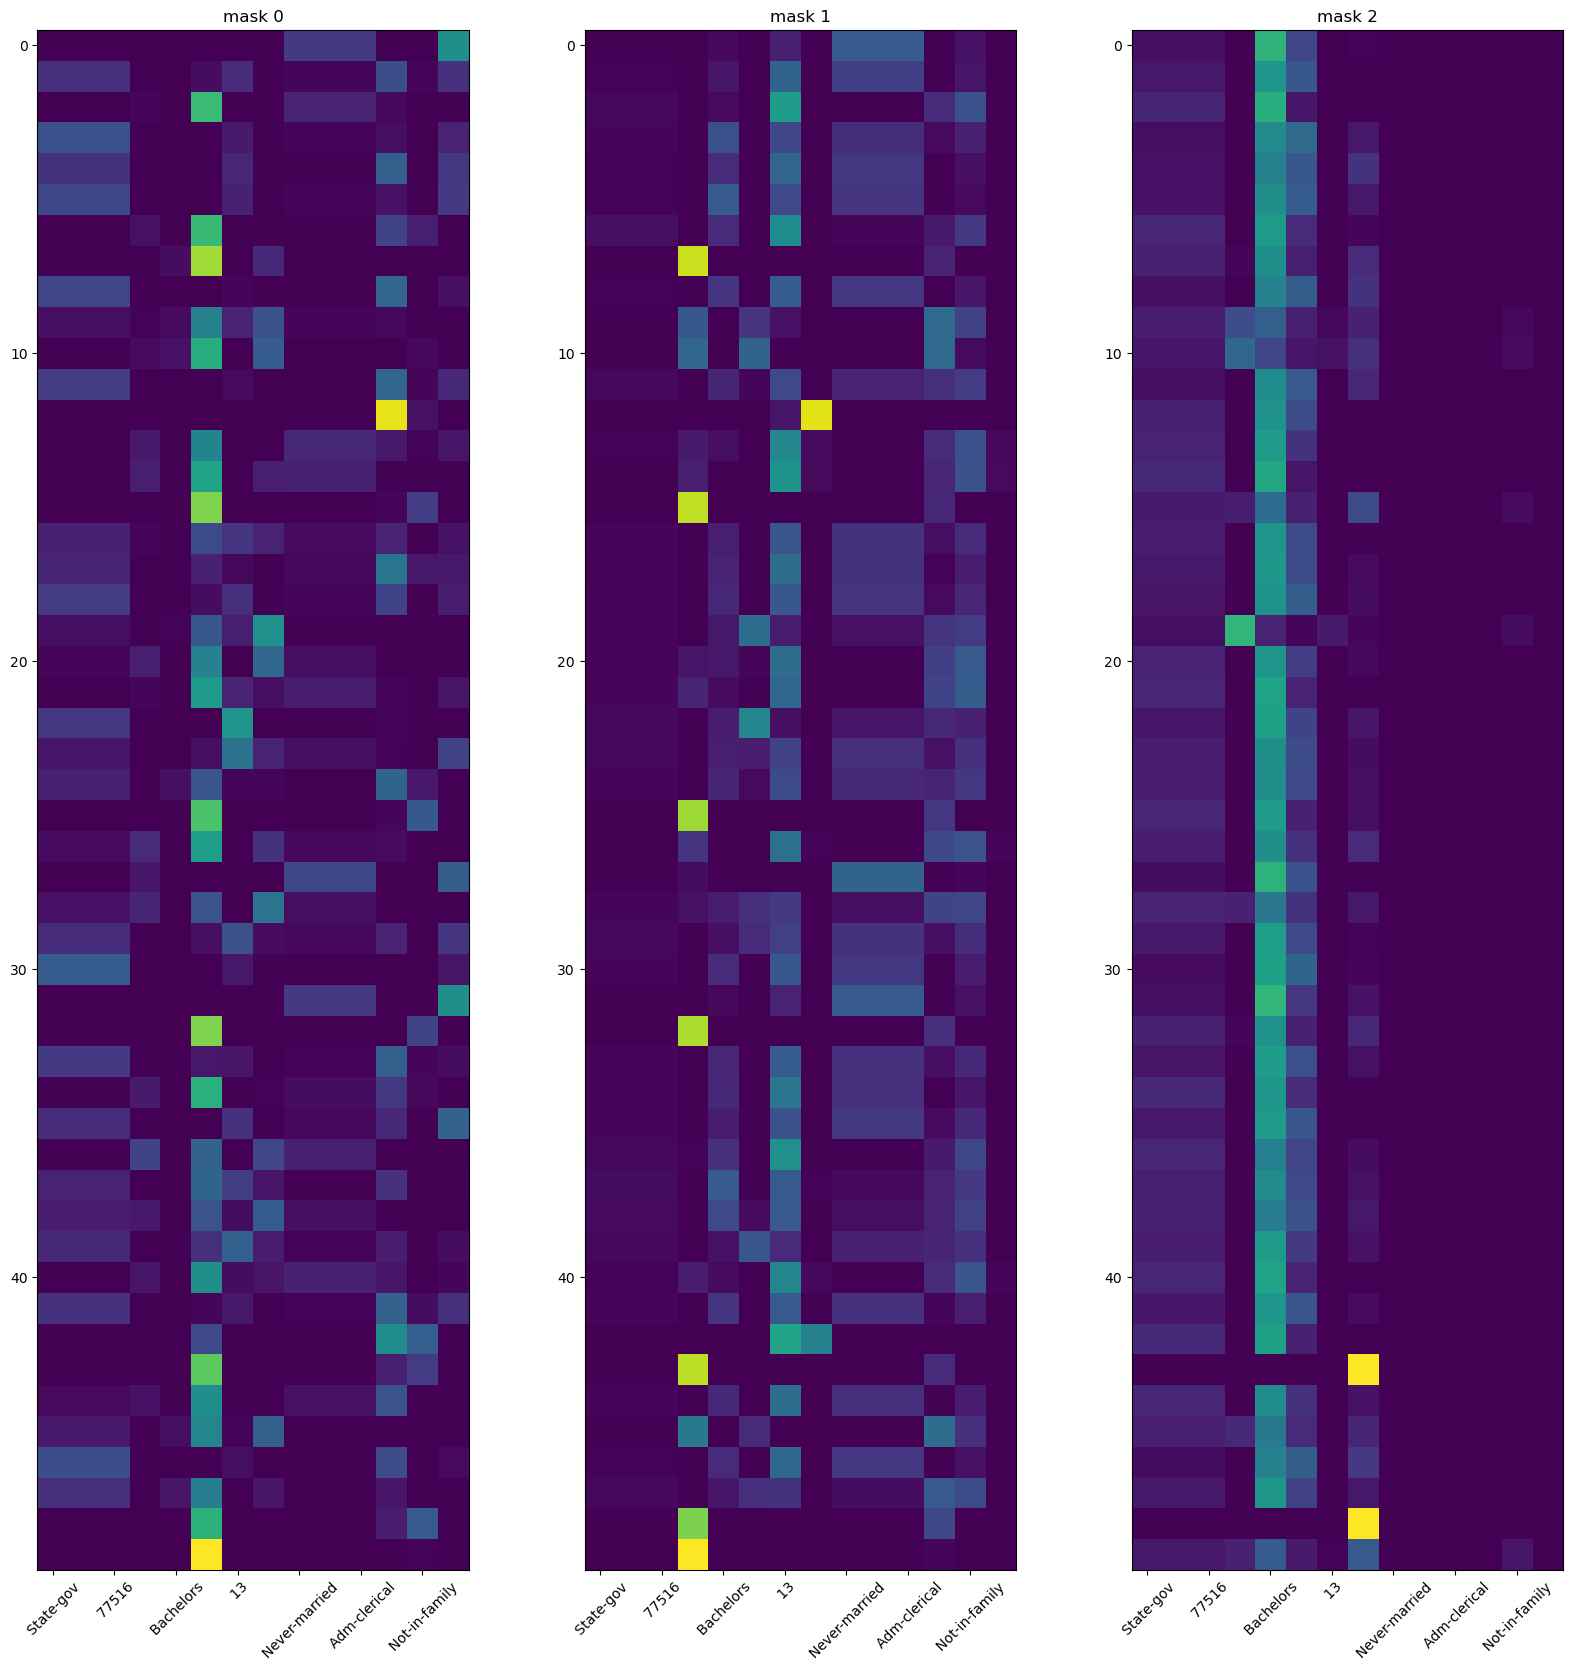

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))


for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticklabels(labels = features, rotation=45)

# XGB

In [47]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)


In [53]:
y_test

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'wealthy'], dtype=object)

In [58]:
y_test_ = y_test == 'wealthy'
y_train_ = y_train == 'wealthy'
y_valid_ = y_valid == 'wealthy'

In [59]:
clf_xgb.fit(X_train, y_train_,
        eval_set=[(X_valid, y_valid_)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-logloss:0.63523
[10]	validation_0-logloss:0.37927


/opt/anaconda/envs/juplab_hk_torch/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.31122
[30]	validation_0-logloss:0.28684
[40]	validation_0-logloss:0.27723
[50]	validation_0-logloss:0.27253
[60]	validation_0-logloss:0.26951
[70]	validation_0-logloss:0.26907
[80]	validation_0-logloss:0.26752
[90]	validation_0-logloss:0.26729
[100]	validation_0-logloss:0.26748
[110]	validation_0-logloss:0.26783
[120]	validation_0-logloss:0.26779
[130]	validation_0-logloss:0.26815
[140]	validation_0-logloss:0.26878
[141]	validation_0-logloss:0.26909


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=8, max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=-1,
              nthread=None, num_parallel_tree=None, predictor=None, ...)

In [60]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid_)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test_)
print(test_auc)

0.9336413537984218
0.9244487257452103
